In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


# Summarizing the Monte Carlo output

The result of a Monte Carlo simulation is a set of samples from the probability distribution associated with the measurand
$$ \{\mathbf{y}^{(k)},\,k=1,\ldots,M\} $$

The aim is to derive characteristic information about the measurand from this set:

1) best estimate

2) uncertainty associated with the best estimate

3) intervals/regions with a prescribed coverage probability

## Univariate measurand

1) best estimate
\begin{align}
y =& mean \{ y^{(k)}, k=1,\ldots,M\} \\
=& \frac{1}{M} \sum_{k=1}^M y^{(k)}
\end{align}
2) uncertainty associated with the best estimate
\begin{align}
u_y =& std\{ y^{(k)}, k=1,\ldots,M\} \\
=& \frac{1}{M-1} \sum_{k=1}^M (y-y^{(k)})^2
\end{align}

### Exercise 4.1

Draw randomly from the normal distribution with mean $\mu=1.3$ and standard deviation $\sigma=0.4$ and calculate best estimate and its uncertainy using 100, 200, 300, ..., 100 000 draws. Compare estimate and uncertainty with mean and standard deviation of the original distribution for the different number of draws.

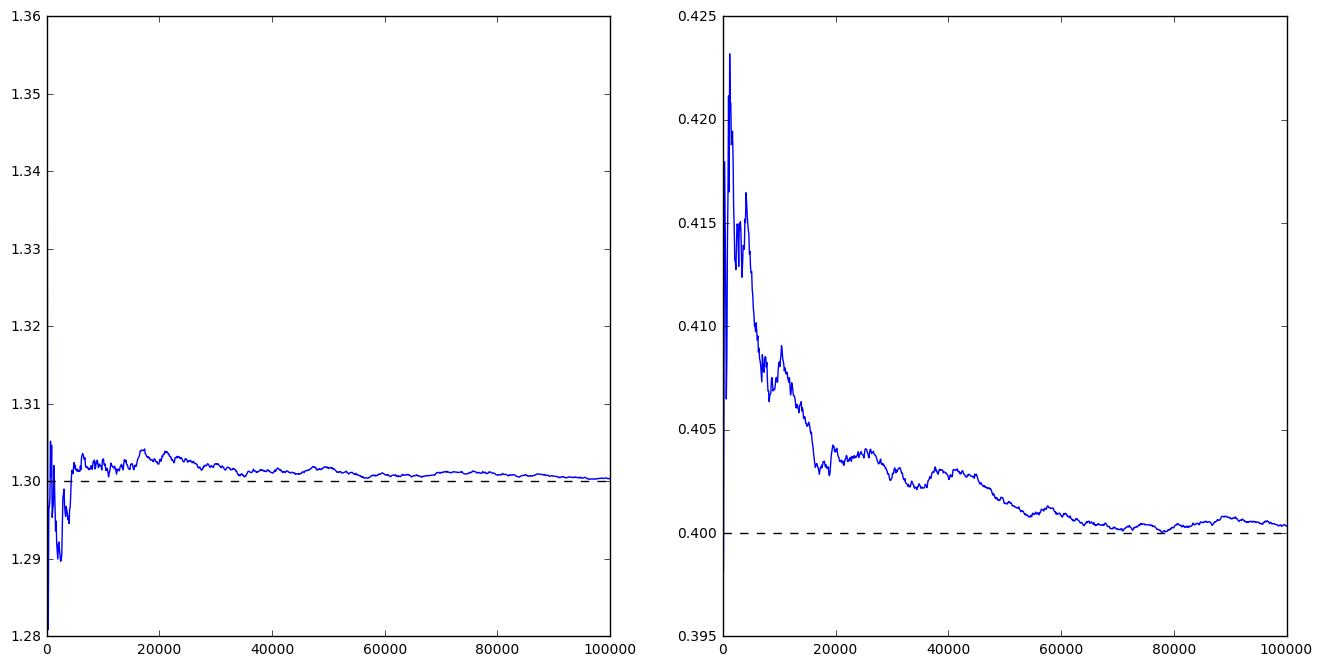

In [2]:
from scipy.stats import norm

Y = norm.rvs(loc=1.3, scale=0.4, size=100000)

draws = arange(100,len(Y)+100,100)
means = array([Y[:M].mean() for M in draws])
uncs  = array([Y[:M].std() for M in draws])

figure()
subplot(121)
plot(draws, means)
axhline(1.3,color="k",linestyle="--")
subplot(122)
plot(draws, uncs)
axhline(0.4,color="k",linestyle="--");

Intervals with a prescribed coverage probability can be calculated from the Monte Carlo outcome as follows

1) Sort the Monte Carlo outcome in ascending order 
``` python
    sort(Y)
```
2) For propability $P$ calculate the corresponding fraction of Monte Carlo draws $q=int(PM)$

3) Set lower bound of interval as $r=int(0.5(M-q))$ for a probabilistically symmetrical interval

4) Calculate upper bound of interval as $r+q$

### Exercise 4.2

Draw randomly from the distribution from Exercise 4.1 and calculate the 95% probabilistally symetrical coverage interval from 1000, 10000 and 100000 draws. Compare the result to the exact 95% interval.

In [3]:
from scipy.stats import norm

P = 0.95 # sought probability of coverage interval

draws = 100000
Y = norm.rvs(loc=1.3, scale=0.4, size=draws)

# step 1 - sort random draws
Ys = sort(Y)
# step 2 - calculate portion of draws corresponding to P
q  = int(draws*P)
# step 3 - set lower bound of coverage interval
r  = int(0.5*(draws-q))
# interval bounds
ylow = Ys[r]
yhigh = Ys[r+q]
interval = [ylow, yhigh]
true_interval = [1.3 - 1.96*0.4, 1.3 + 1.96*0.4]

print("calculated interval")
print(interval)
print("true interval")
print(true_interval)


calculated interval
[0.51871191644717352, 2.082216089835121]
true interval
[0.516, 2.084]


## Multivariate measurand

1) best estimate
\begin{align}
\mathbf{y} =& mean \{ \mathbf{y}^{(k)}, k=1,\ldots,M\} \\
=& \frac{1}{M} \sum_{k=1}^M \mathbf{y}^{(k)}
\end{align}
2) uncertainty associated with the best estimate
\begin{align}
U_\mathbf{y} =& cov\{ \mathbf{y}^{(k)}, k=1,\ldots,M\} \\
=& \frac{1}{M-1} \sum_{k=1}^M (\mathbf{y}-\mathbf{y}^{(k)})(\mathbf{y}-\mathbf{y}^{(k)})^T
\end{align}

### Exercise 4.3

Draw randomly from the normal distribution with mean 
$$\mathbf{\mu}=\left( \begin{array}{c}
0.4 \\ -1.5
\end{array}\right)
$$ 
and covariance
$$
\Sigma=\left(\begin{array}{cc}
0.09 & -0.2 \\ -0.2 & 1.44
\end{array}\right)
$$
and calculate best estimate and its uncertainy using 1000, 10000 and 100 000 draws. Compare estimate and uncertainty with mean and covariance of the original distribution for the different number of draws.

In [4]:
from scipy.stats import multivariate_normal

Y = multivariate_normal.rvs(mean=[0.4, -1.5], 
                            cov = array([[0.09, -0.2],[-0.2, 1.44]]),
                            size = 100000)
draws = [1000, 10000, 100000]
means = array([Y[:M].mean(axis=0) for M in draws])
uncs  = array([cov(Y[:M], rowvar=0) for M in draws])

print("calculated estimates")
print(means)
print("calculated covariances")
print(uncs)

calculated estimates
[[ 0.40676864 -1.48146002]
 [ 0.39609434 -1.48938041]
 [ 0.40065093 -1.49893305]]
calculated covariances
[[[ 0.0858938  -0.19229542]
  [-0.19229542  1.41033116]]

 [[ 0.08787505 -0.19790337]
  [-0.19790337  1.45852861]]

 [[ 0.08906988 -0.19908451]
  [-0.19908451  1.4405801 ]]]


Regions with a prescribed coverage probability can be calculated from the multivariate Monte Carlo outcome as follows

1) Calculate the Cholesky decomposition of the sample covariance matrix $U_{\mathbf{y}}=\mathbf{LL}^T$

2) Transform the Monte Carlo outcomes
$$ \mathbf{y}_{(k)} = \mathbf{L}^{-1}(\mathbf{y}^{(k)}-\mathbf{y})$$
and sort according to the distance measure
$$ d^2_{(k)} = \mathbf{y}_{(k)}^T\mathbf{y}_{(k)} $$

3) calculate $k_P$ such that a fraction $P$ of all Monte Carlo outcomes satisfies $d_{(k)}<k_P$

This defines the ellipsoidal region $(\mathbf{\eta}-\mathbf{y})^TU_{\mathbf{y}}^{-1}(\mathbf{\eta}-\mathbf{y})<k^2_P$

For a bivariate normal distribution, the factor for a 95% coverage ellipsoidal region is given as the 95% quantile of the $\chi^2$ distribution with 2 degrees of freedom.

### Exercise 4.4

Calculate 100 000 random draws from the distribution from Exercise 4.3 and calculate the 95% coverage region. Compare to the true 95% coverage region.

In [5]:
def calculate_ellipse(mu, Sigma, kP):
    vals, vecs = linalg.eigh(Sigma)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:,order]
    theta = degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = kP * sqrt(vals)
    return width, height, theta


In [6]:
from scipy.stats import multivariate_normal, chi2
from matplotlib.patches import Ellipse

mu = array([0.4, -1.5])
Sigma = array([[0.09, -0.2],[-0.2, 1.44]])

dist = multivariate_normal(mean = mu, cov = Sigma)
P = 0.95
draws = 10000
q = int(P*draws)

Y = multivariate_normal.rvs(mean = mu, cov = Sigma, size = draws)

y = Y.mean(axis=0)
Uy= cov(Y, rowvar=0)

# step 1 - Cholesky decomposition of covariance matrix
L = cholesky(Uy)
# step 2 - Transform the Monte Carlo outcomes
Ys = linalg.solve(L, (Y - tile(y,(draws,1))).T).T
d = diag(dot(Ys,Ys.T))
# and sort distances
ds = sort(d)
# step 3 - calculate kP as the scale parameter of the ellipse 
kP = ds[q]
width, height, theta = calculate_ellipse(y, Uy, kP)


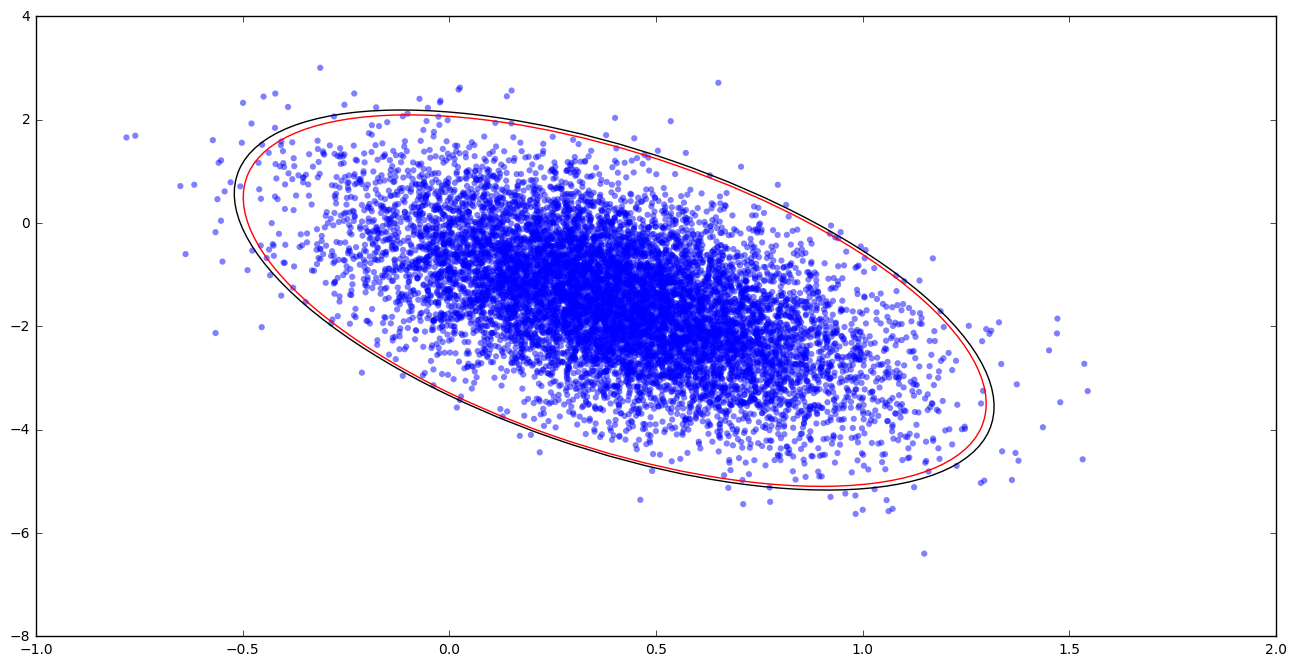

In [8]:
figure()
scatter(Y[:,0],Y[:,1],edgecolor="none",alpha=0.5)
ellip=Ellipse(xy=y, width=width, height=height, angle=theta,facecolor="none")
gca().add_artist(ellip)
w,h,t = calculate_ellipse(mu, Sigma, chi2.ppf(0.95,2))
ellip_true = Ellipse(xy=mu,width=w,height=h,angle=t,facecolor="none",edgecolor="r")
gca().add_artist(ellip_true);